# TMS Analysis
Generating figures 3-5 and S1.

# Imports

Note to self: Modify ```~/.ipython/profile_default/startup/00-add-syspath.py``` to add local directories to jupyter path.

In [7]:
# Remember to login to wandb!
import torch
import matplotlib.pyplot as plt
import copy 

# Atomic save saves the checkpoint in a weird module setup - this is a hack to get around that
import sys
sys.path.append("/root/eigenestimation/eigenestimation")

# Append module directory for imports
import numpy as np
from eigenestimation.toy_models.tms import AutoencoderSymmetric,  AutoencoderParallel  # Import your model
from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss
import notebooks.figure_names as figure_names

# Geneate sparse features
from eigenestimation.toy_models.data import GenerateTMSInputs
import matplotlib.cm as cm
import matplotlib.colors as np_colors

model_path = "../outputs/toy_models/tms.pt"
eigenmodel_path = "../outputs/eigenmodels/tms_parallel.pt"




In [8]:
model_path = "../outputs/toy_models/tms.pt"
eigenmodel_path = "../outputs/eigenmodels/tms_parallel.pt"

model = torch.load(model_path)['model']

# Figure S2: TMS embedding directions

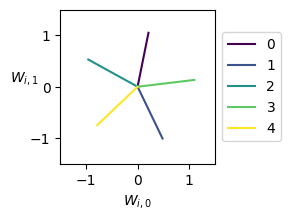

In [9]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 3

model = torch.load(model_path)['model']

# Plot TMS representations.
en = copy.deepcopy(model.W_in).detach().cpu().numpy().transpose()

plt.figure(figsize=(2,2))
# Iterate through different colors
colors = plt.cm.viridis(np.linspace(0, 1, en.shape[1]))

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], '-', color=colors[i], label=f'{i}',)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$W_{i,0}$')
plt.ylabel('$W_{i,1}$', rotation=0)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig(figure_names.tms_encoder_directions, bbox_inches='tight', transparent=True)
plt.show()



# Comparing True network to network sum 

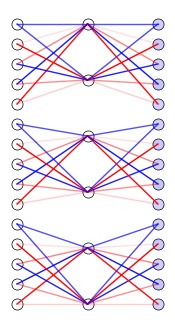

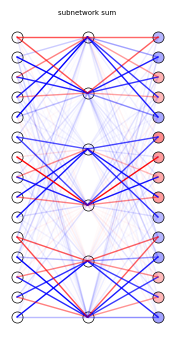

In [10]:
# Load TMS model
input_dim = 5
hidden_dim = 2
n_networks = 3
eigenmodel_checkpoint = torch.load(eigenmodel_path)
eigenmodel = eigenmodel_checkpoint['model']

model_params = dict(eigenmodel.named_parameters())
weights = {k:v for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v.transpose(0,1) for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(2, 4))
a = DrawNeuralNetwork(weights, biases, ax=ax)
plt.show()


model_params = eigenmodel.reconstruct_network()
weights = {k:v.transpose(0,1) for k,v in model_params.items() if 'b' not in k}
weights = {str(i):v for i,v in enumerate(weights.values())}

biases = {k:v for k,v in model_params.items() if 'b' in k}
biases = {str(i+1):v for i,v in enumerate(biases.values())}

f, ax = plt.subplots(figsize=(2, 4))
a = DrawNeuralNetwork(weights, biases, title='subnetwork sum', ax=ax)
plt.show()

# Figure 3: First 5 Subnetworks

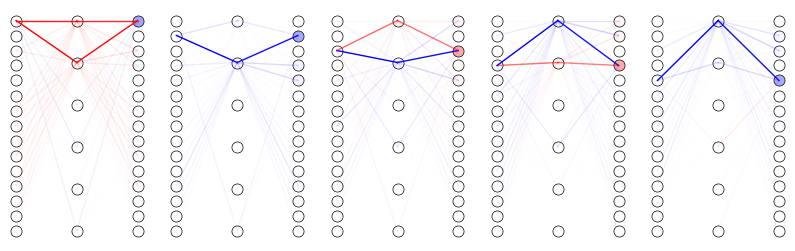

In [11]:
f, axes = plt.subplots(figsize=(10, 3), nrows=1, ncols=5)

subnetworks = eigenmodel.construct_subnetworks()
# Iterate through axes
axes_flat = axes.flatten()
for i, network in enumerate(subnetworks):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    feature_idx = 15 - abs(biases['1']).argmax().item()

    if feature_idx <= 5:
        DrawNeuralNetwork(weights, biases, ax=axes_flat[feature_idx-1])


f.savefig(figure_names.tms_first_5_subnetworks)
plt.show()


In [12]:
figure_names.tms_first_5_subnetworks

'/root/eigenestimation/figures/3_tms_first_5_subnetworks.pdf'

# Figure S1: All Subnetworks

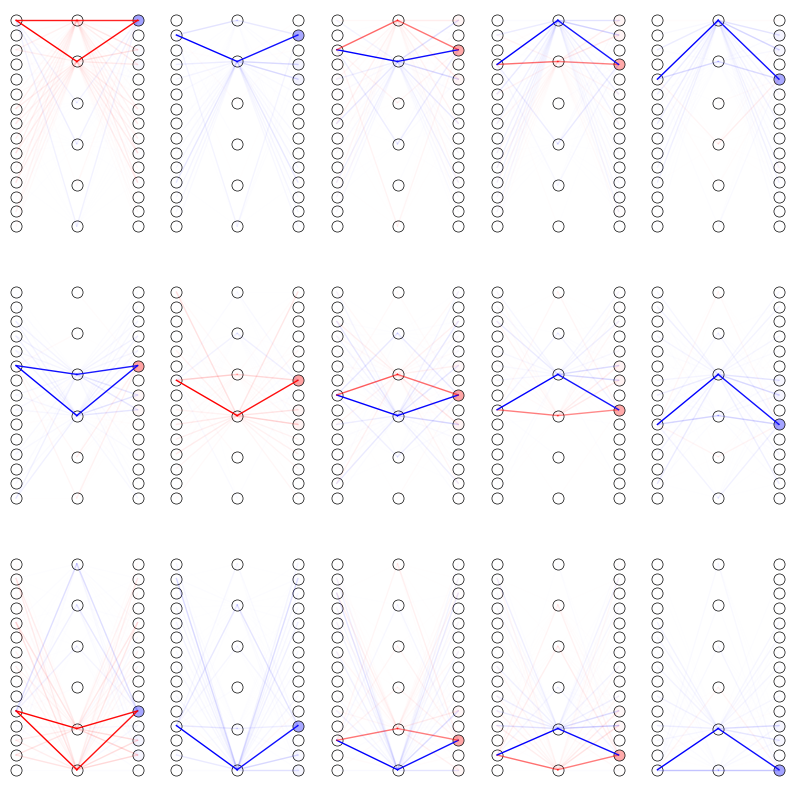

In [13]:
f, axes = plt.subplots(figsize=(10, 10), nrows=3, ncols=5)

subnetworks = eigenmodel.construct_subnetworks()
# Iterate through axes
axes_flat = axes.flatten()
for i, network in enumerate(subnetworks):
    weights = {k:v.transpose(0,1) for k,v in network.items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in network.items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}

    feature_idx = 15 - abs(biases['1']).argmax().item()
    DrawNeuralNetwork(weights, biases, ax=axes_flat[feature_idx-1])

f.savefig(figure_names.tms_full_subnetworks, bbox_inches='tight', transparent=True)
plt.show()

# Feature Intervention

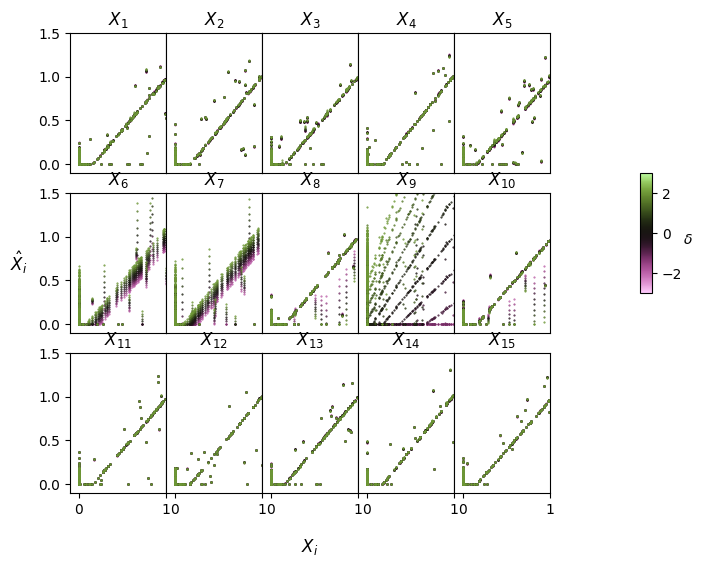

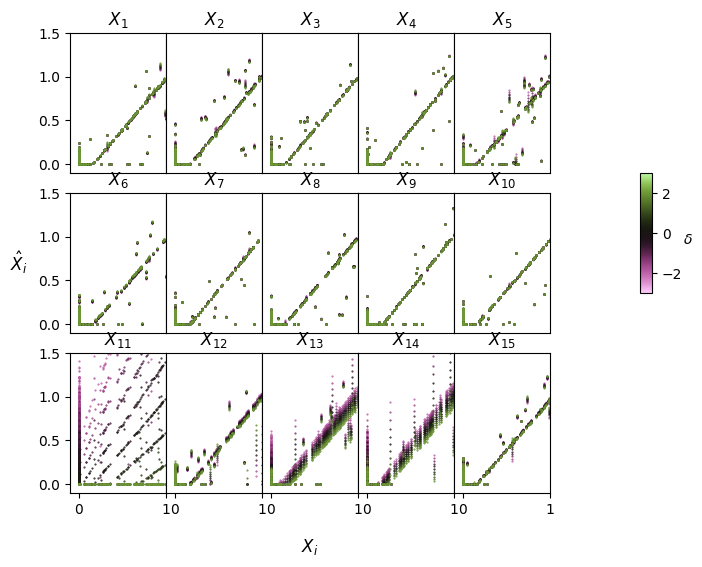

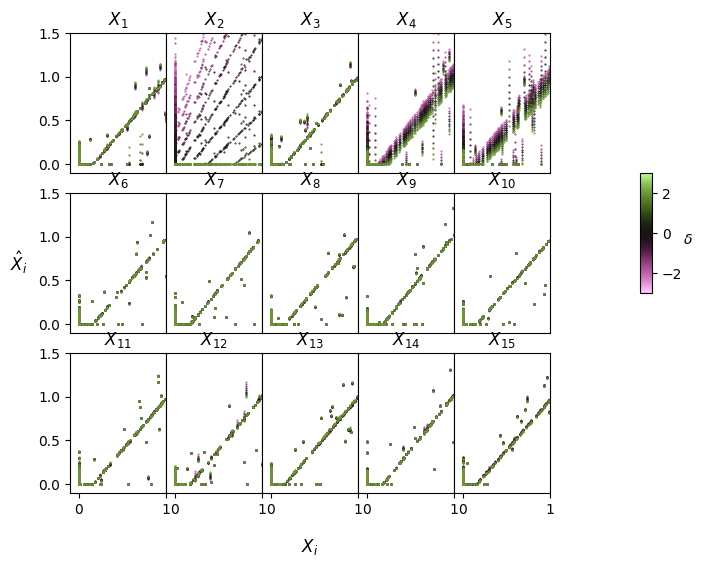

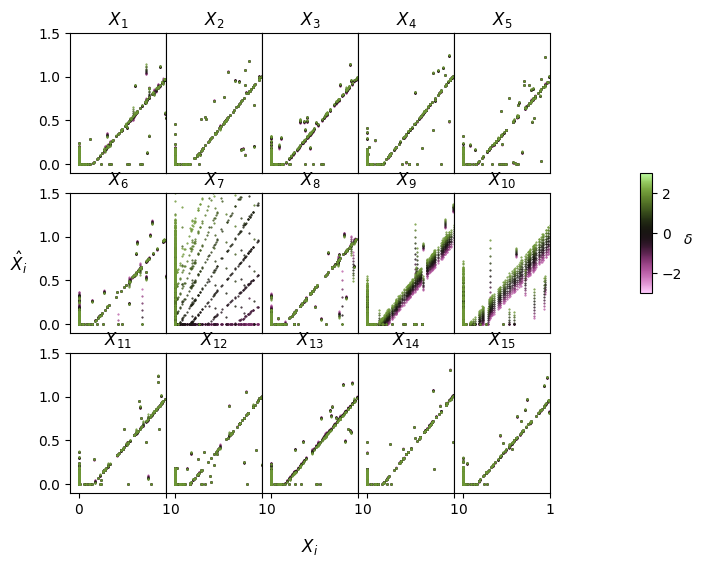

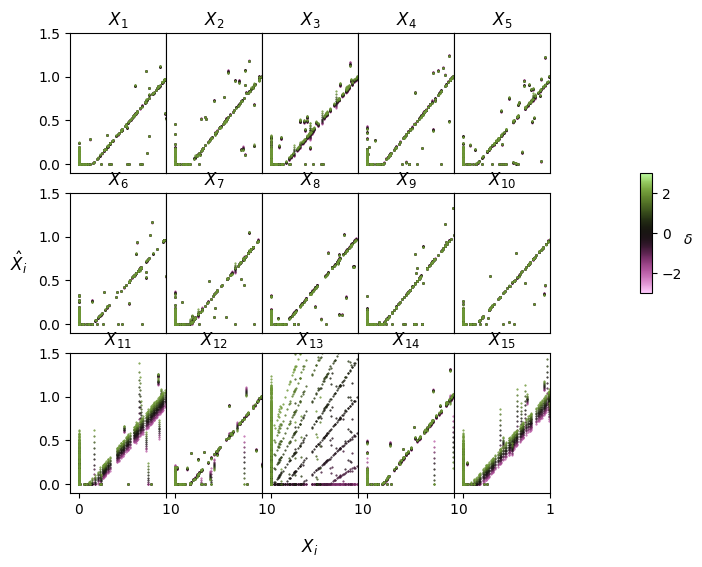

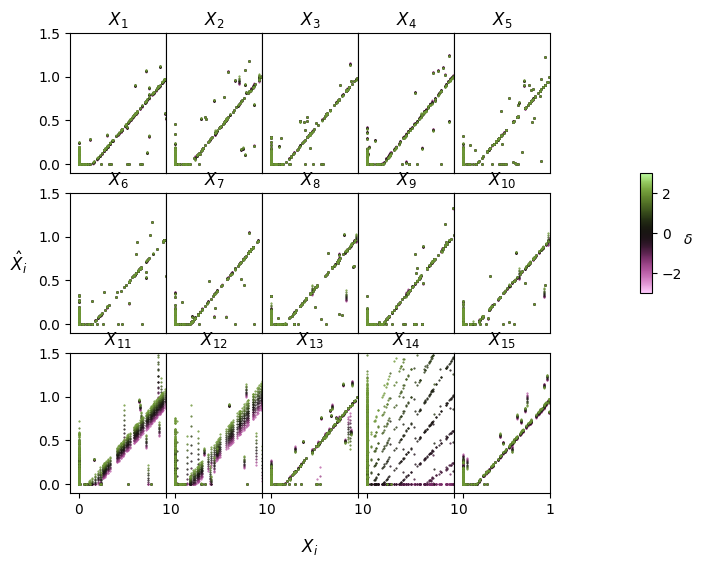

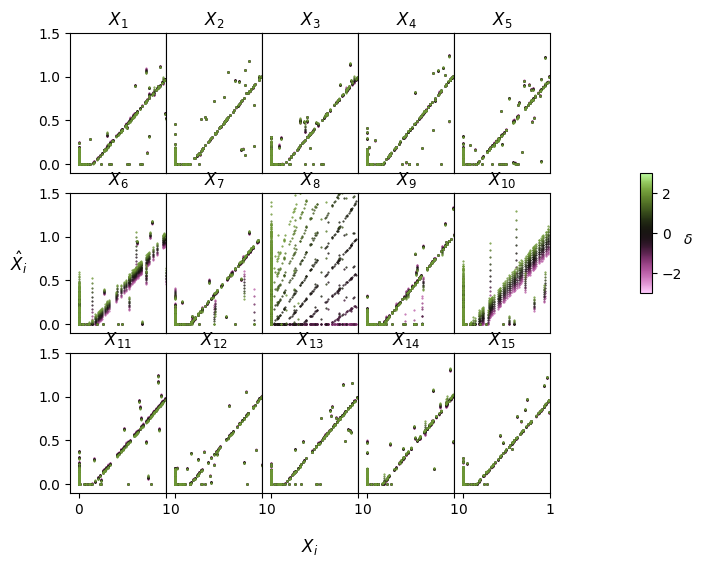

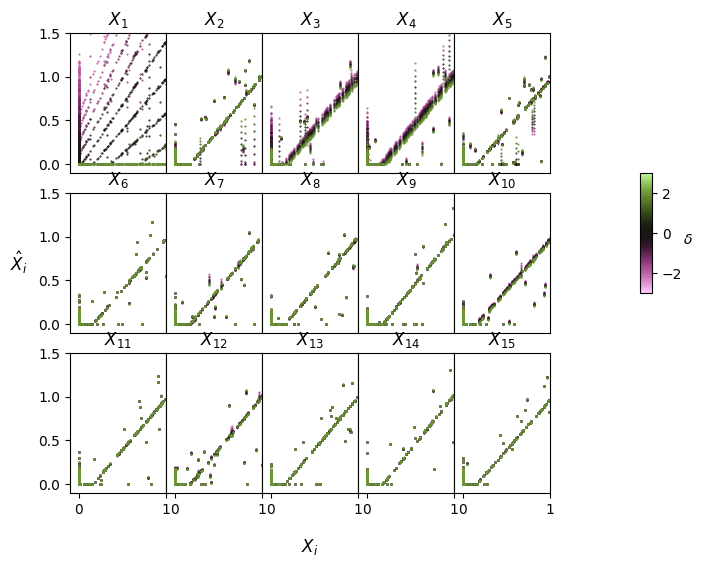

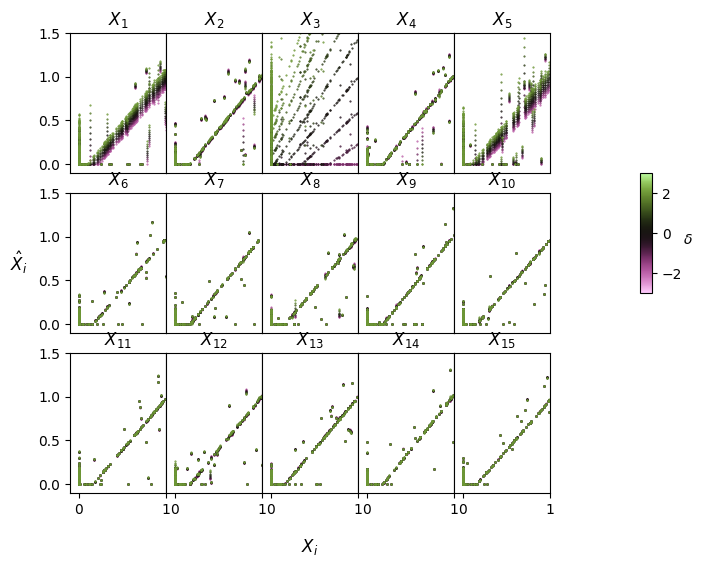

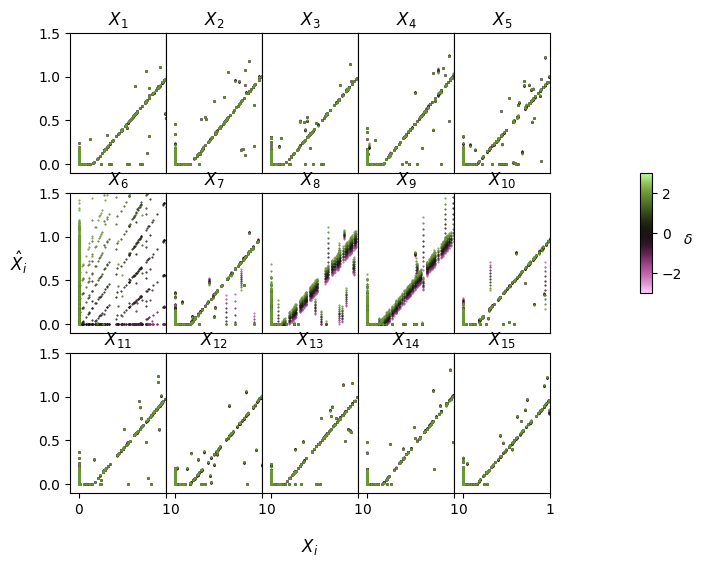

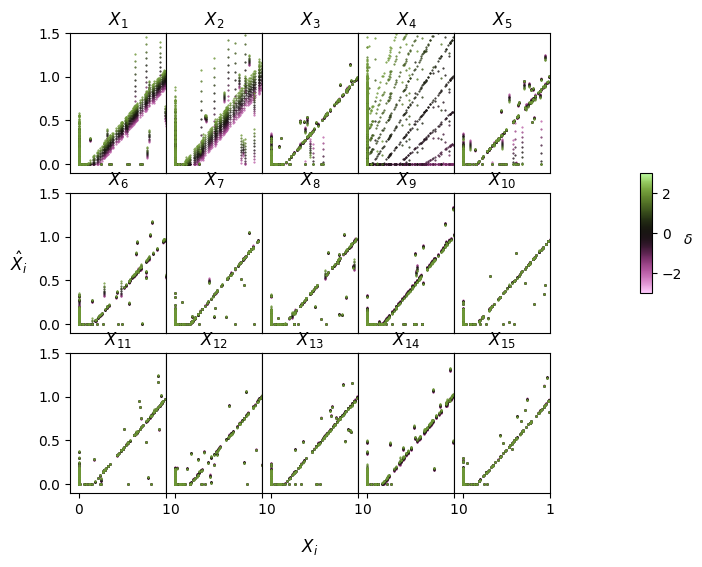

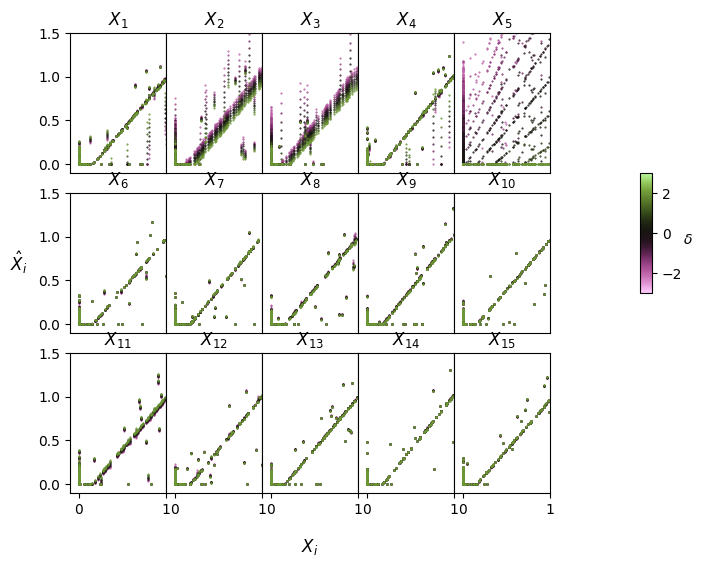

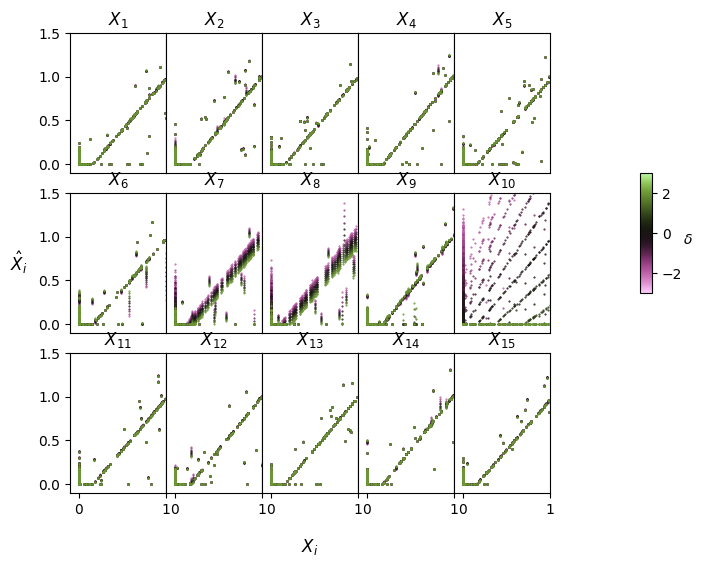

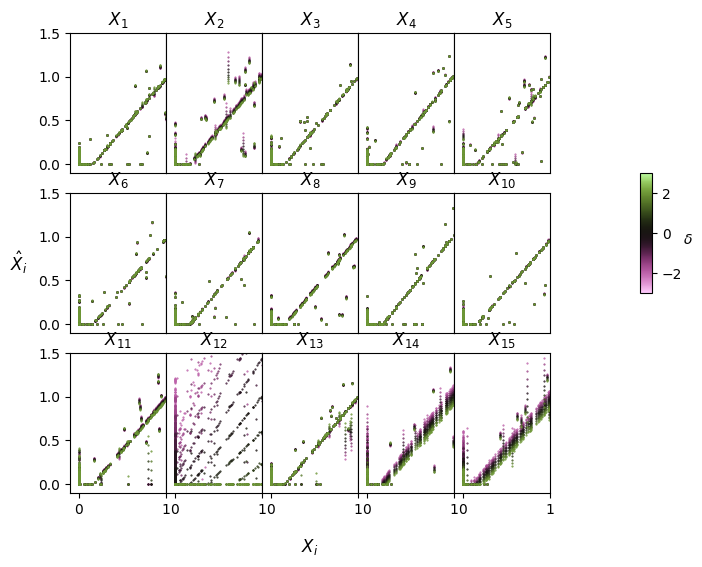

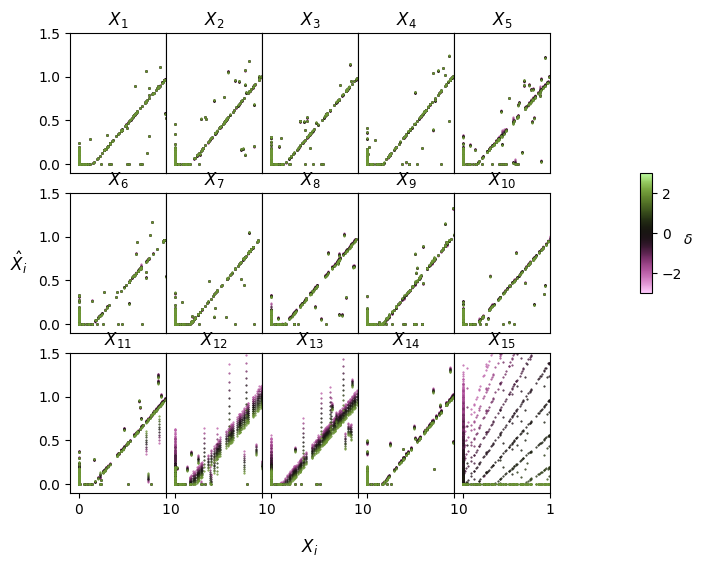

In [22]:


subnetworks = eigenmodel.construct_subnetworks()

n_subnetworks = len(subnetworks)
n_features = 15
X = GenerateTMSInputs(num_features=n_features, num_datapoints=1000, sparsity=.05)


toy_model = copy.deepcopy(eigenmodel.model)
y_orig = toy_model(X).cpu().detach().numpy()

figs = []


    
    
for subnetwork_idx in range(15):

    weights = {k:v.transpose(0,1) for k,v in subnetworks[subnetwork_idx].items() if 'b' not in k}
    weights = {str(i):v for i,v in enumerate(weights.values())}

    biases = {k:v for k,v in subnetworks[subnetwork_idx].items() if 'b' in k}
    biases = {str(i+1):v for i,v in enumerate(biases.values())}
    
    n_cols = 5  # You can adjust this number to change the grid layout
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division to ensure all plots fit



    norm = np_colors.Normalize(vmin=-3, vmax=3)  # normalize based on feature_coeff range
    cmap = plt.cm.vanimo  # you can choose different colormaps like 'viridis', 'plasma', 'magma', etc.

    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6, 2*n_rows))
    axes = axes.flatten()  # Flatten axes array for easier indexing    
    # Create individual scatter plots
    for i in range(n_features):

    
        for feature_coeff in np.linspace(-2,2, 11):
            feature_coefficients = torch.zeros(eigenmodel.n_features).to('cuda')
    
            # Iterate through different values of features coefficient and plot on the
            feature_coefficients[subnetwork_idx] = feature_coeff
            reconstruction = eigenmodel.add_to_network(feature_coefficients)
            # Repalce toy model parameters with model_params
            toy_model.load_state_dict(reconstruction)
            y = (toy_model(X)).cpu().detach().numpy()
        # Calculate number of rows and columns for subplots grid
            axes[i].plot(X[:,-(i+1)].detach().cpu().numpy(), y[:,-(i+1)],#X[:,-(i+1)].cpu().detach().numpy(), y[:,-(i+1)], 
                         '.', 
                        label=f"feature coeff {feature_coeff}", markersize=1, color=cmap(norm(feature_coeff)))# vmin=-3, vmax=3)

        axes[i].set_title(f'$X_{{{i+1}}}$')
        # Make my plots have the same x and y ratios
        axes[i].set_ylim(-.1,1.5)
        axes[i].set_xlim(-.1,1)

        axes[i].set_aspect('equal', 'box')
        # For plots other than 0,4,8 no y labels
        if i not in [0,5,10]:
            axes[i].set_yticks([])
        
        # For plots other than 0,1,2,3,4 no x labels
        if i not in [10,11,12,13,14]:
            axes[i].set_xticks([])
            
    # Remove any empty subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
        
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed for colorbar compatibility

    # Add a colorbar outside all subplots
    # Create a separate axis for the colorbar
    cbar_ax = fig.add_axes([1.05, 0.45, 0.02, 0.2])  # [left, bottom, width, height]
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar to this independent axis
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.set_label("$\delta$", rotation=0, loc='center', size=10)

    # Ensure subplots are tightly packed but leave space for the colorbar
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0, hspace=0)

    # Set sup y label and x label
    
    fig.supxlabel('$X_{{i}}$')
    # Rotate ylabel
    fig.supylabel('$\hat{X}_{{i}}$', rotation=0, x=0)
    
    plt.savefig(figure_names.tms_intervention_all % (subnetwork_idx+1), bbox_inches='tight', transparent=True)
    
    if (subnetwork_idx+1)==5:
        plt.savefig(figure_names.tms_intervention, bbox_inches='tight', transparent=True)